In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import glob
sns.set()
from results import load

#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

# Reading the results

In [3]:
#config
experiment_name = "full"
providers = ["aws","azure","ibm","gcf"] 
num_repetitions = 1
configs = ["0,0,1", "0,0,2","0,0,0.5"] # "60,60,1","60,60,2","60,60,0.5"]

all = load(experiment_name, providers,configs,num_repetitions,True)
all.columns

reading 0,0,1 aws 1
reading 0,0,1 azure 1
reading 0,0,1 ibm 1
reading 0,0,1 gcf 1
reading 0,0,2 aws 1
reading 0,0,2 azure 1
reading 0,0,2 ibm 1
reading 0,0,2 gcf 1


b'Skipping line 4058: expected 15 fields, saw 20\n'


reading 0,0,0.5 aws 1
reading 0,0,0.5 azure 1
reading 0,0,0.5 ibm 1
reading 0,0,0.5 gcf 1


Index(['RId', 'WL', 'CId', 'CStart', 'ELat', 'RSuccess', 'Phase', 'RStart',
       'EStart', 'EEnd', 'REnd', 'CPlat', 'COs', 'RInput', 'Provider', 'RLat',
       'RResult', 'run', 'sourceFile', 'RCode', 'HId'],
      dtype='object')

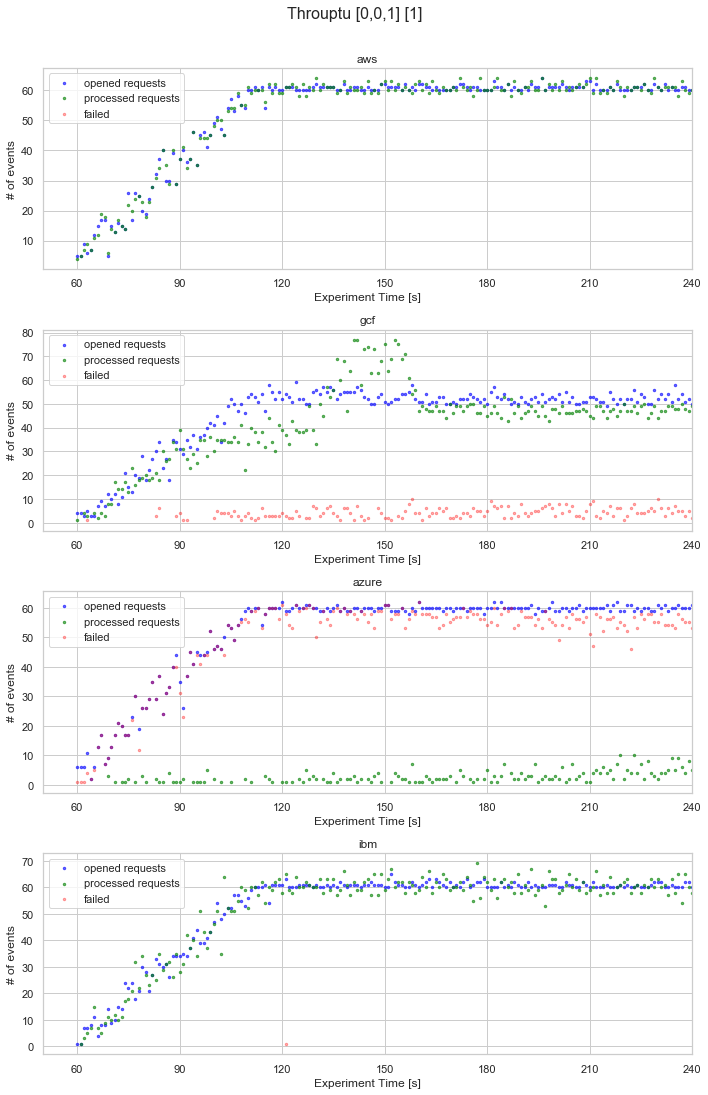

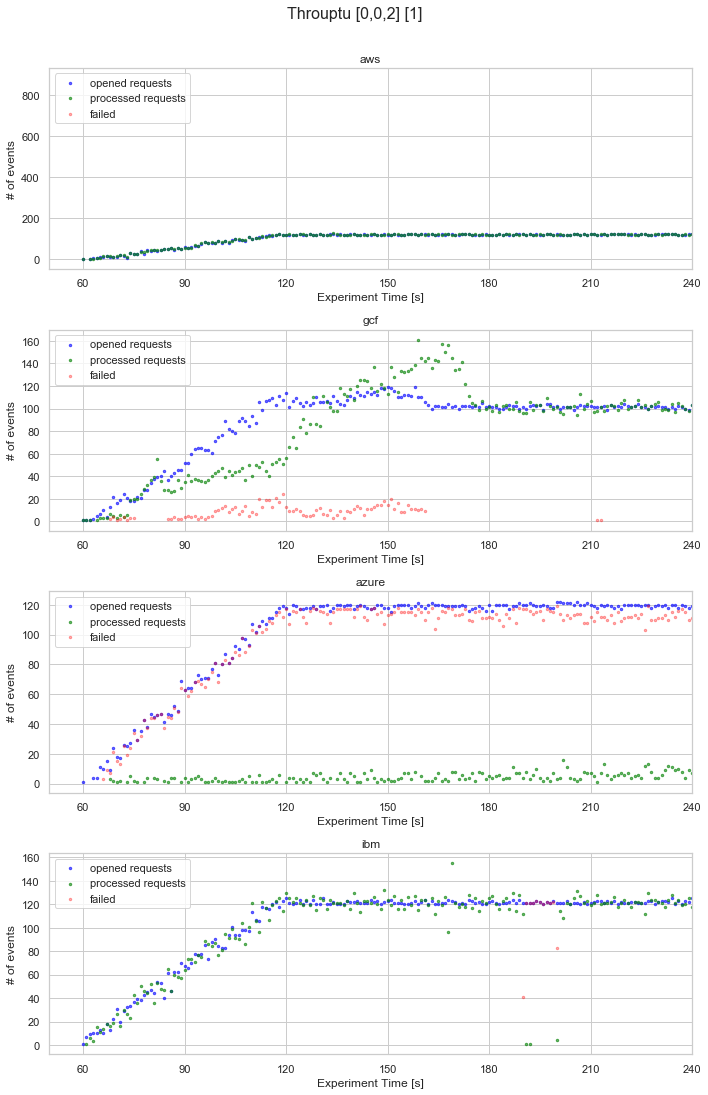

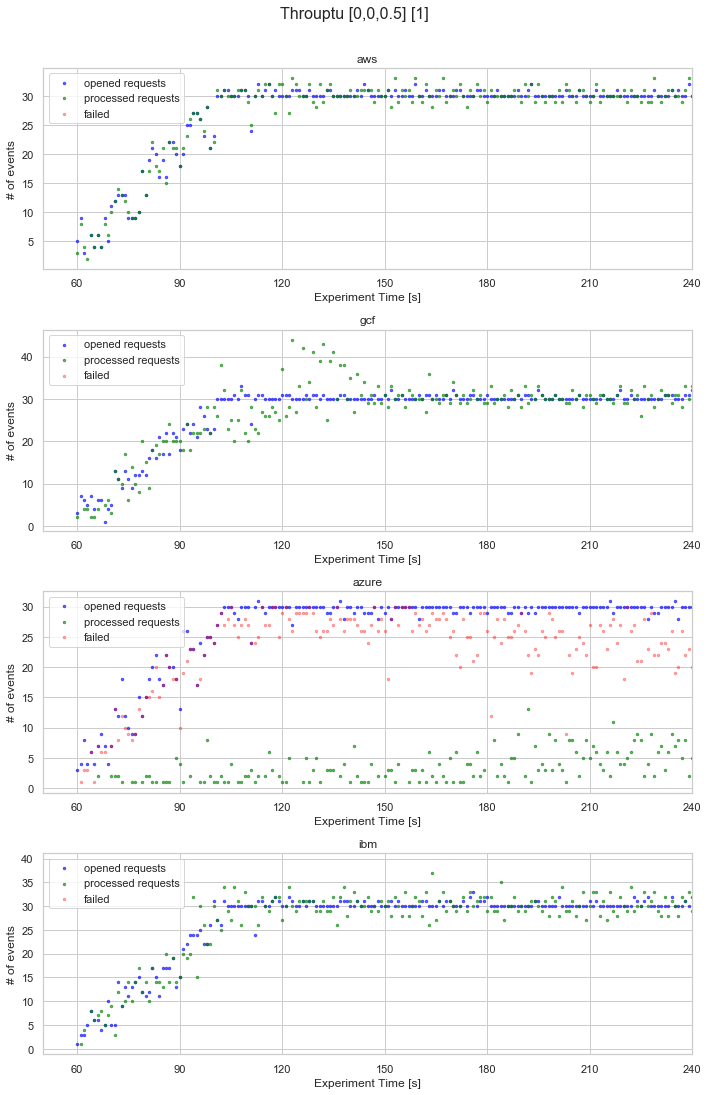

In [18]:
for WL in configs:
    WL_data = all[all['WL'] == WL]
    fig, axs = plt.subplots(int(len(WL_data['Provider'].unique())),1, sharex=False, sharey=False,figsize=(10.0, 16.0))
    plt.suptitle("Throuptu [%s] [%d]"%(WL,1), fontsize=16)
    idx = 0
    for provider in WL_data['Provider'].unique():
        data = WL_data[WL_data['Provider'] == provider] 
        data = data.sort_values(by="RStart")
        data['RStart_per_sec']=round(data['RStart']/1000)
        data['EStart_per_sec']=round(data['EStart']/1000)
        A = data.groupby('RStart_per_sec')['RId'].count().reset_index(name='c')
        axs[idx].scatter(x='RStart_per_sec', y='c', data=A, color="blue",alpha=0.6, s=6)

        B = data.groupby('EStart_per_sec')['RId'].count().reset_index(name='c')
        axs[idx].scatter(x='EStart_per_sec', y='c', data=B, color="green",alpha=0.6, s=6)

        data = data[data['RCode'] > 200]
        B = data.groupby('RStart_per_sec')['RId'].count().reset_index(name='c')
        axs[idx].scatter(x='RStart_per_sec', y='c', data=B, color='red',alpha=0.33, s=6)

        axs[idx].legend(["opened requests", "processed requests","failed"], loc='upper left')
        axs[idx].set(xlabel='Experiment Time [s]', ylabel='# of events', title=provider)
        axs[idx].set_xticks(np.arange(0, 300, 30))
        
        axs[idx].set_xlim(50,240)
        # axs[idx].set_ylim(0,100)
        idx+=1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


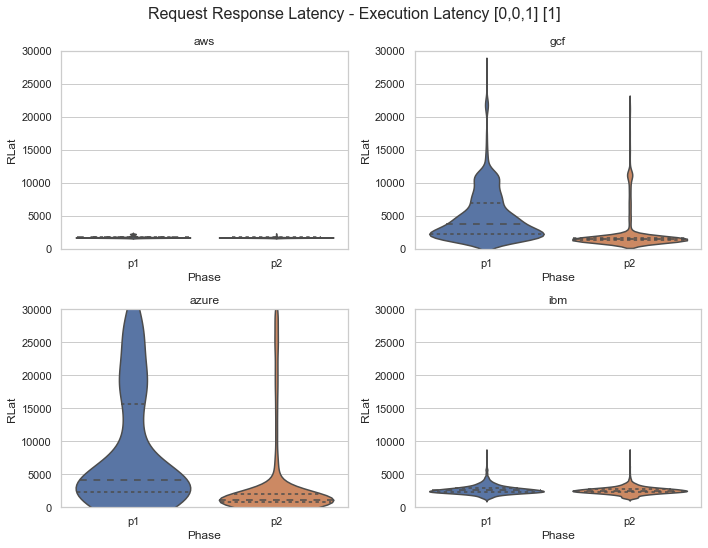

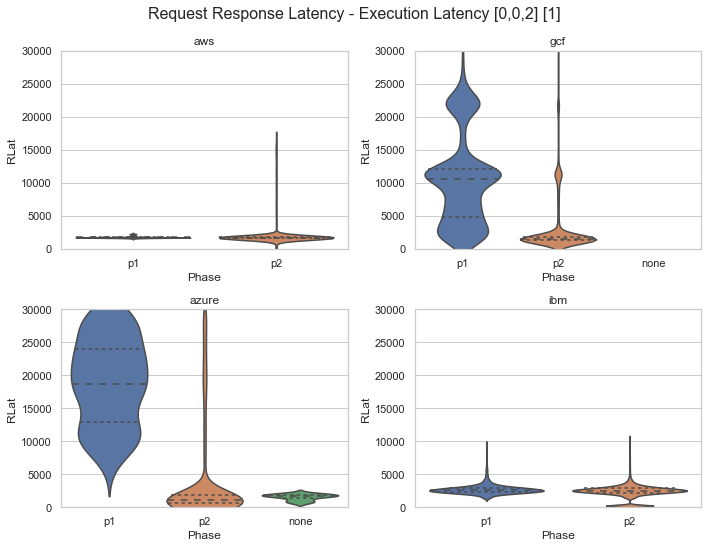

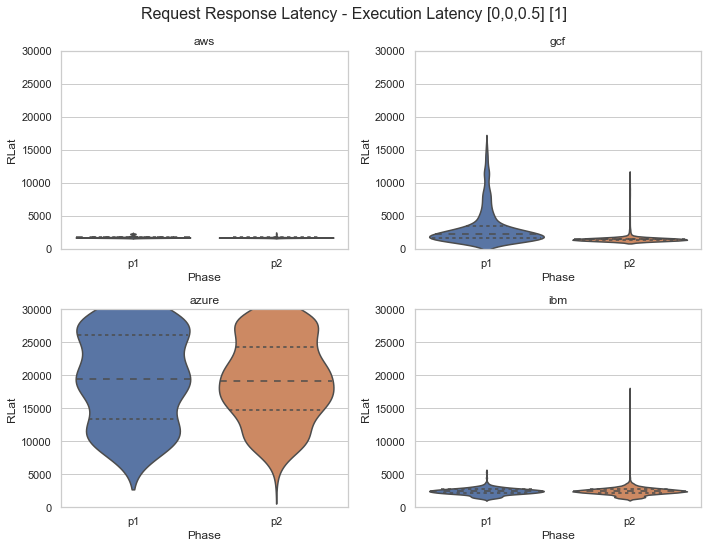

In [7]:
for config in configs:
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 8.0))
    
    plotId = 221
    plot = 0
    for run in all['run'].unique():
        plt.suptitle("Request Response Latency - Execution Latency [%s] [%d]"%(config,run), fontsize=16)
        for provider in all['Provider'].unique():
            plt.subplot(plotId)
            plt.title(provider)
            plt.ylim(0, 30000)
            plotId += 1
            plot+=1
            data = all[all["WL"] == config]
            data = data[data["Provider"] == provider]
            data = data[data["run"] == run]
            sns.violinplot(x='Phase', y='RLat', data=data, scale='width', inner='quartile')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
def failures(all):
    data = all
    window =  data[['rovider','label','failed']]
    w = window.groupby(['provider','label','failed'])
    w = w['failed'].count().reset_index(name="#")
    total = w.groupby(['provider','label'])["#"].sum().reset_index(name="total")
    def get(x):
        return int(total[(total['provider'] ==x['provider']) & (total['label'] == x['label'])].total)
    w["failed req. [%]"] = w.apply(lambda x: x["#"]/get(x),axis=1)
    failed_req = w
    return w[w['failed']==True][["provider",'label',"failed req. [%]"]]

def latancy(data):
    rows=["provider","phase","median","90%","99%","max"]
    colm = []
    for provider in data['provider'].unique():
        #data = data[data['failed'] == False]
        for phase in experiment_phase_labels:
            window = data[data["label"]==phase]
            lastSendInPhase=experiment_phase[phase]
            window=window['requestResponseLatency']
            colm.append([provider,phase,"%.2f" %window.quantile(0.5),"%.2f" %window.quantile(0.9),"%.2f" %window.quantile(0.99),"%.2f" %window.max()])

        
    perf_qualities = pd.DataFrame(colm,columns=rows)
    return perf_qualities
    


### Thrughput

In [ ]:
phase_time = experiment_phase
rows=["provider","phase","mean thr","target thr","relative thr???"]
colm = []
provider="gcf"
run = 2
for provider in all['provider'].unique():
    data = all[all['provider'] == provider]
    data = data[data['failed'] == False]
#     data = data[data["run"]==2]
    for phase in experiment_phase_labels:
        window = data[data["label"]==phase]
        lastSendInPhase=phase_time[phase]
        thr_mean = window[window['m4'] < lastSendInPhase]["m4"].count()/60.0/num_repetitions
        thr_target = window['m1'].count()/60.0/num_repetitions
        colm.append([provider,phase,"%.1f" %thr_mean,"%.1f" %thr_target,"%.1f" %((thr_mean*100)/thr_target)])
    
thr_qualities = pd.DataFrame(colm,columns=rows)
with open('./reports/thr_per_phase.csv',"w") as f:
    f.write(thr_qualities.to_csv())
thr_qualities

### Performance

In [ ]:

rows=["provider","phase","median","90%","99%","max"]
colm = []
for provider in providers:
    data = all[all['provider'] == provider]
    data = data[data['failed'] == False]
#     data = data[data["run"]==2]
    for phase in experiment_phase_labels:
        window = data[data["label"]==phase]
        lastSendInPhase=phase_time[phase]
        window=window[window['m1'] < lastSendInPhase]['requestResponseLatency']
        colm.append([provider,phase,"%.2f" %window.quantile(0.5),"%.2f" %window.quantile(0.9),"%.2f" %window.quantile(0.99),"%.2f" %window.max()])
    
perf_qualities = pd.DataFrame(colm,columns=rows)
perf_qualities
with open('./reports/perf_per_phase.csv',"w") as f:
    f.write(perf_qualities.to_csv())
perf_qualities

### Exec and NonExec Lat 

In [ ]:
data = all
data = data[data['failed'] == False]
window =  data[['provider','label','nonExecutionLatency','executionLatency','deliveryLatency','newContainer']]
def _max(n):
    return np.max(n)
_max.__name__ = "max"
def _size(n):
    return len(n)
_size.__name__= "req. [#]"
foo = window.groupby(['provider','label','newContainer'])
exec_nonexec_lat = foo.agg([percentile(90), percentile(99),_max])
exec_nonexec_lat["req. [#]"] = foo["nonExecutionLatency"].agg([_size])
with open('./reports/container_exec_nonexec_per_phase.csv',"w") as f:
    f.write(exec_nonexec_lat.to_csv())

style_map = exec_nonexec_lat.columns.get_loc_level('p_90', level=1)[0] | exec_nonexec_lat.columns.get_loc_level('p_99', level=1)[0] | exec_nonexec_lat.columns.get_loc_level('max', level=1)[0] 

cm = sns.light_palette("green", as_cmap=True)

exec_nonexec_lat.style.format("{:.2f}",subset=style_map)


### Failed Requests

In [ ]:
data = all
window =  data[['provider','label','failed']]
w = window.groupby(['provider','label','failed'])
w = w['failed'].count().reset_index(name="#")
total = w.groupby(['provider','label'])["#"].sum().reset_index(name="total")
def get(x):
    return int(total[(total['provider'] ==x['provider']) & (total['label'] == x['label'])].total)
w["failed req. [%]"] = w.apply(lambda x: x["#"]/get(x),axis=1)

with open('./reports/failed_req.csv',"w") as f:
    f.write(w[w['failed']==True][["provider",'label',"failed req. [%]"]].to_csv())
failed_req = w
w[w['failed']==True][["provider",'label',"failed req. [%]"]]

In [ ]:

for run in range(1,num_repetitions+1):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 8.0))
    plt.suptitle("Opened Requests and Started Containers per Cloud Provider [%d]"%run, fontsize=16)
    #plt.subplot(221)
    #ax = sns.boxplot(x="requestTime_per30sec", hue="provider", y="requestResponseLatency", data=all, palette="Set3", )
    #ax2 =  ax.twinx()
    #plt.subplot(412)
    plotId = 221
    for provider in all['provider'].unique():
        ax = plt.subplot(plotId)
        plotId += 1
        data = all[all['provider'] == provider]
        data = data[data["run"]==run]
        data = data.sort_values(by="m1")
        data['m1_bucket']=round(data['m1']/1000)
        data['m2_bucket']=round(data['m2']/1000)
        A = data.groupby('m1_bucket')['m1'].count().reset_index(name='c')
        plt.scatter(x='m1_bucket', y='c', data=A, color=labels[provider]["color"],alpha=0.6)
        B = data.groupby('m2_bucket')['m2'].count().reset_index(name='c')
        plt.scatter(x='m2_bucket', y='c', data=B, color=labels[provider]["colorB"],alpha=0.6)
#         X = B.rename(columns={"m2_bucket":"x"})['c']-A.rename(columns={"m1_bucket":"x"})['c']
#         X = X[0:360]
#         ax = sns.lineplot( data=X, color=labels[provider]["color"], markers=True)

        failedExecutions = data[data['statusCode'] >= 400]
        C = failedExecutions.groupby('m1_bucket').size().reset_index(name='counts')
    #     failedExecutions = failedExecutions[['requestTime_per5sec', 'requestTime_normalized']].groupby(['requestTime_per5sec']).count().reset_index()
    #     failedExecutions['failures'] = failedExecutions['requestTime_normalized'].rolling(20, min_periods=1).mean() * 10
        sns.lineplot(x='m1_bucket', y='counts', data=C, color='red', markers=True)

        ax.legend(["opened requests", "failed requests"], loc='upper left')
    #     ax.set_xlim([0,380])
    #     ax.set_ylim([0,140])
        ax.set(xlabel='Experiment Time [s]', ylabel='# of events', title=labels[provider]["name"])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
for run in range(1,num_repetitions+1):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 8.0))
    plt.suptitle("Request Response Latency - Execution Latency [%d]"%run, fontsize=16)


    plotId = 221
    plot = 0
    for provider in providers:
        plt.subplot(plotId)
        plotId += 1
        plot+=1
        data = all[all["provider"] == provider]
        data = data[data["run"] == run]

        ax = sns.scatterplot(x="experimentTime", y="nonExecutionLatency", data = data, palette = {"New":"#f086c0","Reused":"#5b8dde"}, hue="newContainer")

        requestsPerSecond = data[['requestTime_per5sec', 'requestTime_normalized']].groupby(['requestTime_per5sec']).count().reset_index()
        requestsPerSecond['startedRequests'] = requestsPerSecond['requestTime_normalized'].rolling(10, min_periods=1).mean() * 10
        ax2 = ax.twinx()
        sns.lineplot(x='requestTime_per5sec', y='startedRequests', data=requestsPerSecond, color="gray", markers=True)

        ax.set_ylim(bottom=0,top=labels[provider]["y-lim"])
        ax.set_xlim(left=0, right=360)

        if plot == 1:
            ax.legend(loc='upper left')
        else:
            ax.get_legend().remove()

        ax2.set_ylim(bottom=0)
        ax2.set_xlim(left=0)

        if plot > 2:
            ax.set(xlabel='Experiment Time [s]', title=labels[provider]["name"])
        else:
            ax.set(xlabel='', title=labels[provider]["name"])

        if plot%2 ==1:
            ax.set(ylabel='Non-Execution Latency [s]')
            ax2.set(ylabel='')
        else:
            ax.set(ylabel='')
            ax2.set(ylabel='Number of Sent Requests')
        ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: "{0:.0f}".format(x)))    



    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
for config in configs:
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 8.0))
    plt.suptitle("Request Response Latency - Execution Latency [%d]"%run, fontsize=16)
    plotId = 221
    plot = 0
    for provider in providers:
        for run in range(1, num_repetitions+1):
            plt.subplot(plotId)
            plt.title(provider)
            plotId += 1
            plot+=1
            data = all[all["config"] == config]
            data = data[data["provider"] == provider]
            data = data[data["run"] == run]
            sns.violinplot(x='label', y='requestResponseLatency', data=data, scale='width', inner='quartile')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
for config in configs:
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 18.0))
    plt.suptitle("Request Response Latency - Execution Latency [%d]"%run, fontsize=16)
    plotId = 411
    plot = 0
    for provider in providers:
        for run in range(1, num_repetitions+1):
            plt.subplot(plotId)
            plt.title(provider)
            plotId += 1
            plot+=1
            data = all[all["config"] == config]
            data = data[data["provider"] == provider]
            data = data[data["run"] == run]
            data['time'] = round(data['m1']/1000)
            data = data.groupby(['requestResponseLatency', 'time']).size().reset_index(name='counts')
            sns.stripplot(data.time, data.requestResponseLatency, size=data.counts)
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
plt.figure(figsize=(10,8))
pltId = 1
for provider in providers:
    plt.subplot(2, 4, pltId)
    data = all[all["provider"] == provider]
    ax = sns.boxplot(x="newContainer", y="executionLatency", color=labels[provider]["color"], data = data)
    ax.set(ylabel='Execution Latency [s]', xlabel="", title=labels[provider]["name"])
    ax.get_xaxis().set_ticks([])
    plt.subplot(2, 4, pltId+4)
    ax2 = sns.boxplot(x="newContainer", y="nonExecutionLatency", color=labels[provider]["color"], data = data)
    pltId += 1
    ax2.set(ylabel='Non-Execution Latency [s]', xlabel="")
    ax2.get_xaxis().labelpad = 20
plt.tight_layout()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

plt.savefig("./reports/Container1.pdf")

In [ ]:
plt.figure(figsize=(10,6))
pltId = 1
for provider in providers:
    plt.subplot(2, 2, pltId)
    ax = sns.countplot(x="label", hue="newContainer", data = all[all["provider"] == provider], palette=[labels[provider]["colorB"], labels[provider]["color"]])
    #ax.set_ylim(0, 18000)
    ax.set_yscale("log")
    ax.set(title=labels[provider]["name"])
    if pltId == 1:
        ax.set(ylabel="Number of Requests", xlabel="")
    elif pltId >= 3:
        ax.set(ylabel="", xlabel="Target Workload")
    else:
        #ax.get_yaxis().set_ticks([])
        ax.set(ylabel="", xlabel="")
    pltId += 1
    ax.legend(["New", "Reused"], loc='upper left')

plt.tight_layout()
plt.savefig("./reports/Container2.pdf")